## Goals:

- load the G from layers for miniaste
- create the G_advh from offline monthly avg.
- load the gateways (make sure indices)
- verify this way
- now verify the M term

## setup

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the curre nt kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/prep_grid_aste_90.py"

(450, 90)
RAC2d (40500,)
(100,)


In [2]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirbudg = layers_path + "diags/BUDG/"
dirdiags = dirbudg
dirstate = layers_path + "diags/STATE/"
dirlayers = layers_path + "diags/LAYERS/"
dirtrsp = layers_path + "diags/TRSP/"

In [3]:
# maybe we can dump a file to load the aste90 grid so I can have all the values

## Make sure we have the bins

In [4]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

## Load the G_T and G_S terms

In [5]:
# we need to also create the theta and salt bins for this area
tsstr = np.array(["0000000002","0000000003"])
tsstr = np.array(["0000000003","0000000004"])

t2 = int(tsstr[1]) # for the offline version

In [6]:
ffac=1e-6

In [7]:


def _mark_points(mask, xs, ys, code, ny, nx, name="gate"):
    """
    Mark (y, x) points in mask with 'code'.
    If a point already has a different non-NaN code, set it to 3 (overlap).
    Bounds are clipped to the grid silently.
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if xs.shape != ys.shape:
        raise ValueError(f"{name}: x/y length mismatch: {xs.shape} vs {ys.shape}")

    # clip to valid indices just in case
    xi = np.clip(xs.astype(int), 0, nx-1)
    yi = np.clip(ys.astype(int), 0, ny-1)

    for j, i in zip(yi, xi):
        cur = mask[j, i]
        if np.isnan(cur):
            mask[j, i] = code
        elif cur == code or cur == 3:
            # already same code or already overlap — leave as is
            continue
        else:
            mask[j, i] = 3  # overlap with different code
    return mask

In [8]:
# do the same copying over but for SALT terms (from the original verification on 12/15)
############################################################
# define the mask here
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ind = ind.reshape(ny,nx)
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ysmsk,xsmsk = np.where(mymsk==1)[0],np.where(mymsk==1)[1]

# define the gates for the miniaste

# these are the indices we want to read from, but not write to
# at y = 186, we want -ADVy
x_bsoh = np.array([54, 54, 54, 54, 54])
x_bsov = np.array([0,  1,  2,  3,  4,  5,  6,  7,  8,  9])    # from Norway to Sp
y_bsoh = np.array([145, 146, 147, 148, 149])
y_bsov = np.array([186, 186, 186, 186, 186, 186, 186, 186, 186, 186])    # from Norway to Sp

x_spfjh = np.array([20,20,20,23,24,24,26,26])    # vertical gates from Sp to Fj as -x
y_spfjh = np.array([185,184,183,182,181,180,179,178])
x_spfjv = np.array([20,21,22,23,24,25,26])          # horizontal gates where we want to read -y
y_spfjv = np.array([183,183,183,183,182,180,180])

y_fjnzv = np.arange(165,175,1)
x_fjnzv = np.full_like(y_fjnzv,27)    # horizontal gate where we want to read -x

y_nzruv = np.arange(152,155,1)
x_nzruv = np.full_like(y_nzruv,12)   # horizontal gate where we want to read -x

# gates_mask starts as NaN everywhere
gates_mask = np.full((ny, nx), np.nan, dtype=float)

# ---- mark H gates with code = 1 ----
gates_mask = _mark_points(gates_mask, x_bsoh, y_bsoh, 1, ny, nx, name="bsoh")
gates_mask = _mark_points(gates_mask, x_spfjh, y_spfjh, 1, ny, nx, name="spfjh")

# ---- mark V gates with code = 2 ----
gates_mask = _mark_points(gates_mask, x_bsov,  y_bsov,  2, ny, nx, name="bsov")
gates_mask = _mark_points(gates_mask, x_spfjv, y_spfjv, 2, ny, nx, name="spfjv")
gates_mask = _mark_points(gates_mask, x_fjnzv, y_fjnzv, 1, ny, nx, name="fjnzv")
gates_mask = _mark_points(gates_mask, x_nzruv, y_nzruv, 1, ny, nx, name="nzruv")

# Optional: if you prefer 0 instead of NaN for “not a gate”
# gates_mask = np.nan_to_num(gates_mask, nan=0.0)

# let's make a mask of these to double check that we did this correctly
gates_mask[182,23] = 3
gates_mask[180,24] = 3 
gates_mask[180,26] = np.nan
gates_mask[182,24] = np.nan
gates_mask[183,23] = np.nan


testmsk = gates_mask.copy()
testmsk[:,:19] = np.nan
testmsk[:,30:] = np.nan
testmsk[:178,:] = np.nan
y_spfjv2,x_spfjv2 = np.where(testmsk == 2)[0],np.where(testmsk == 2)[1]
y_spfjh2,x_spfjh2 = np.where(testmsk == 1)[0],np.where(testmsk == 1)[1]
y_spfjb2,x_spfjb2 = np.where(testmsk == 3)[0],np.where(testmsk == 3)[1]
RAC = mygrid['RAC']

############################################################
# from tsstr, loop through and generate the actual values from the output

# define the layers
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

# read from T and S
t2 = int(tsstr[1])
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

## Create the ADVh terms from the salt and temp

In [9]:
from create_aste90_layers import create_layers_totalTHETA,create_layers_totalSALT

In [10]:
Msum, dF_Tnew = create_layers_totalTHETA(tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy)

## verify these manually

In [11]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

## Create the M term from the gates

We need to find the previous notebook where I marked the gates. Not sure what I called it.

try_again_BarentsSwhole.ipynb

In [12]:
## I think the best way to do this is with the ADV_TH term

In [13]:
labels = np.array(["ADVh","ADVr","DFh","DFr","surf","kpp","tend"])

s = 0 
print("gates       ",np.nansum(np.nansum(Msum,axis=0))/np.nansum(binwidthT1),"m^3/s")
for i in range(6):
    at = np.nansum(dF_Tnew[i]) / np.nansum(binwidthT1)
    print(labels[i],"       ",at,"m^3/s")
    s += at
print()
print("total volume tend RHS: ",s,"m^3/s")
print("total volume tend LHS: ",np.nansum(dF_Tnew[-1]/1.9131428585e3) / np.nansum(binwidthS1),"m^3/s")

gates        265872.3371250672 m^3/s
ADVh         265872.3371250672 m^3/s
ADVr         -2.2253824948265377e-11 m^3/s
DFh         106.12036325954855 m^3/s
DFr         1.7803059958612301e-10 m^3/s
surf         -646325.4887748167 m^3/s
kpp         5.563456237066344e-12 m^3/s

total volume tend RHS:  -380347.0312864898 m^3/s
total volume tend LHS:  -380347.0312333998 m^3/s


## Load the salt terms and the gates from SLT

In [14]:
Msum, dF_Snew = create_layers_totalSALT(tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy)

In [15]:
s = 0
print("gates       ",np.nansum(np.nansum(Msum,axis=0))/np.nansum(binwidthS1),"m^3/s")
for i in range(6):
    at = np.nansum(dF_Snew[i]) / np.nansum(binwidthS1)
    print(labels[i],"       ",at,"m^3/s")
    s += at
print()
print("total volume tend RHS: ",s,"m^3/s")
print("total volume tend LHS: ",np.nansum(dF_Snew[-1]/1.8e3) / np.nansum(binwidthS1),"m^3/s")

gates        -111565.45142993073 m^3/s
ADVh         -111565.45142993085 m^3/s
ADVr         -2.36526368156312e-10 m^3/s
DFh         30.725026611431016 m^3/s
DFr         -4.157690065247672e-12 m^3/s
surf         -7434.17458396522 m^3/s
kpp         -1.8478622512211875e-13 m^3/s

total volume tend RHS:  -118968.90098728487 m^3/s
total volume tend LHS:  -118968.90098808928 m^3/s


In [16]:
# great, now we can wrap all of this for tsstr2--5

## how many timesteps do we have?

- '0000000002' -- '0000000003'
- '0000000003' -- '0000000004'
- '0000000004' -- '0000000005'

In [17]:

labels = np.array(["ADVh","ADVr","DFh","DFr","surf","kpp","tend"])  # keep as you had

# how many budget windows (pairs of ts strings)
tsstrfull = np.array(["0000000002","0000000003","0000000004"])
nt = len(tsstrfull) - 1
nterms = 6  # ADVh..kpp (exclude "tend" because you’re comparing RHS vs LHS)

# columns: [gates, ADVh, ADVr, DFh, DFr, surf, kpp, RHS, LHS, residual]
colnames = ["gates"] + list(labels[:nterms]) + ["RHS", "LHS", "residual"]
out_T = np.full((nt, len(colnames)), np.nan, dtype=float)
out_S = np.full((nt, len(colnames)), np.nan, dtype=float)

# optional: store the pair label for each row
pair_ids = np.array([f"{tsstrfull[i]}-{tsstrfull[i+1]}" for i in range(nt)])

for it in range(nt):
    tsstr = tsstrfull[it:it+2]

    MsumT, dF_Tnew = create_layers_totalTHETA(
        tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy
    )
    MsumS, dF_Snew = create_layers_totalSALT(
        tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy
    )

    # ---------- THETA ----------
    gates_T = np.nansum(MsumT) / np.nansum(binwidthT1)
    terms_T = np.array([np.nansum(dF_Tnew[i]) / np.nansum(binwidthT1) for i in range(nterms)])
    rhs_T   = np.nansum(terms_T)
    lhs_T   = np.nansum(dF_Tnew[-1] / 1.9131428585e3) / np.nansum(binwidthS1)
    res_T   = rhs_T - lhs_T

    out_T[it, :] = np.concatenate(([gates_T], terms_T, [rhs_T, lhs_T, res_T]))

    # ---------- SALT ----------
    gates_S = np.nansum(MsumS) / np.nansum(binwidthT1)
    terms_S = np.array([np.nansum(dF_Snew[i]) / np.nansum(binwidthT1) for i in range(nterms)])
    rhs_S   = np.nansum(terms_S)
    lhs_S   = np.nansum(dF_Snew[-1] / 1.9131428585e3) / np.nansum(binwidthS1)
    res_S   = rhs_S - lhs_S

    out_S[it, :] = np.concatenate(([gates_S], terms_S, [rhs_S, lhs_S, res_S]))

# now you have:
# out_T[it, :] and out_S[it, :] for each window, with column labels in colnames
# pair_ids tells you which ts pair each row corresponds to

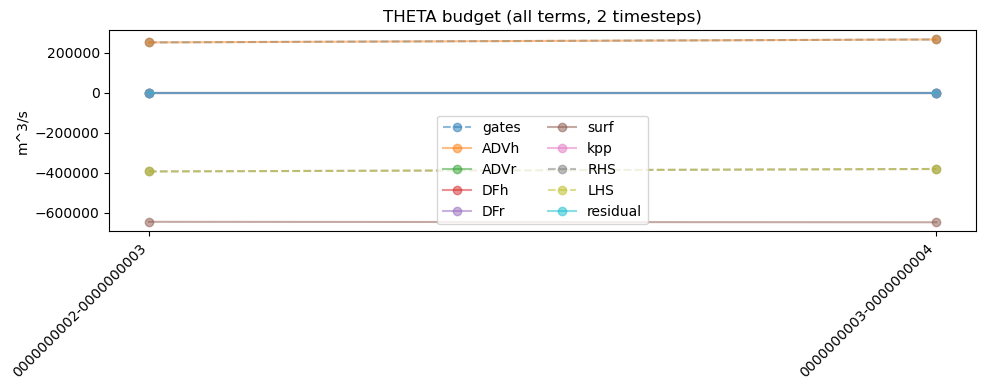

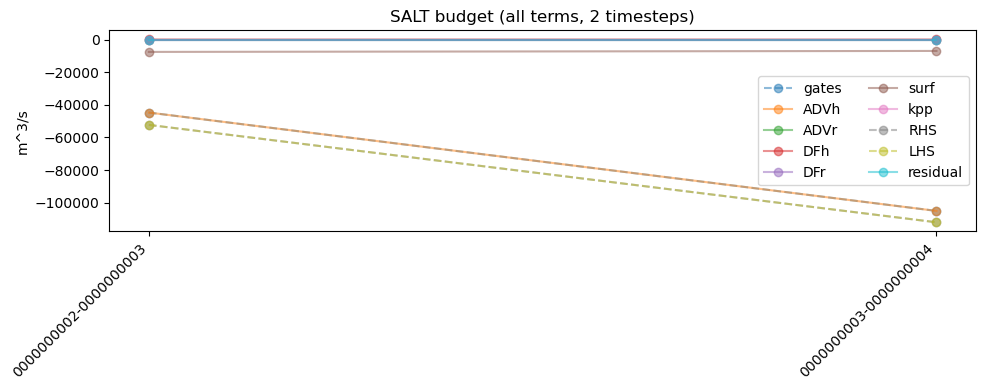

In [18]:
x = np.arange(len(pair_ids))  # 0..nt-1

def plot_all_terms(out, title):
    plt.figure()

    special = {"gates", "RHS", "LHS"}  # dashed
    for j, name in enumerate(colnames):
        ls = "--" if name in special else "-"
        plt.plot(x, out[:, j], linestyle=ls, marker="o", label=name,alpha=0.5)

    plt.xticks(x, pair_ids, rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("m^3/s")
    plt.legend(ncols=2)
    plt.tight_layout()
    plt.show()

plot_all_terms(out_T, "THETA budget (all terms, 2 timesteps)")
plot_all_terms(out_S, "SALT budget (all terms, 2 timesteps)")

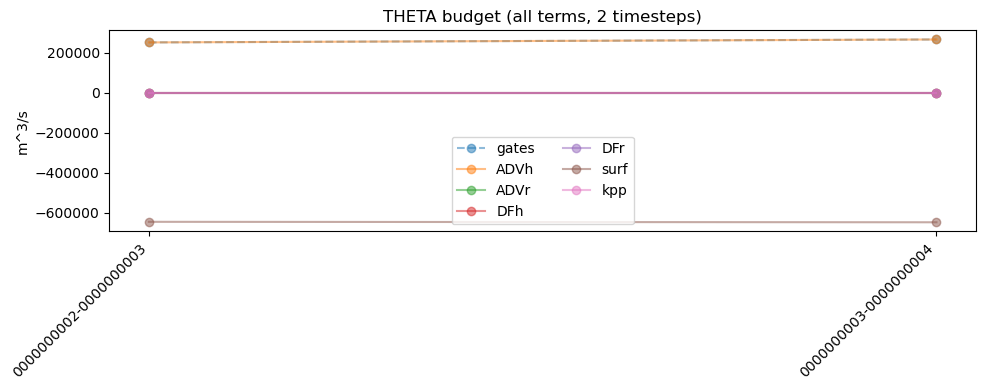

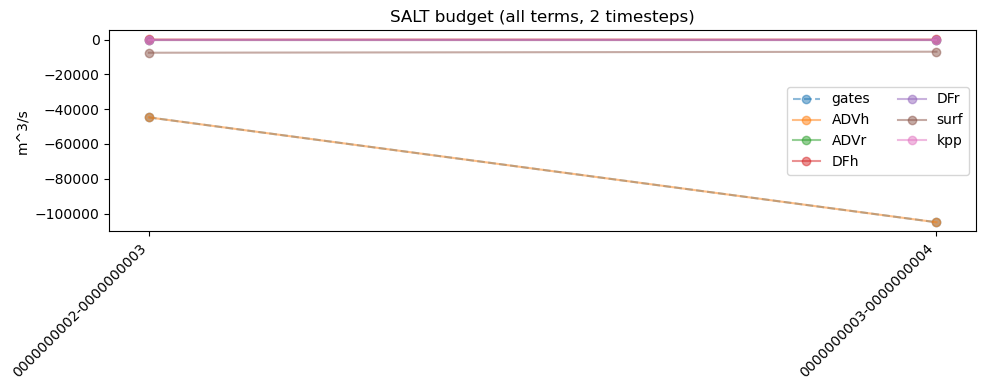

In [19]:
# great, verified
x = np.arange(len(pair_ids))  # 0..nt-1

def plot_all_terms(out, title):
    plt.figure()

    # remove these from the plot
    exclude = {"LHS", "RHS", "residual"}

    # keep existing styling rule for dashed lines (won't matter for excluded terms)
    special = {"gates", "RHS", "LHS"}  # dashed

    for j, name in enumerate(colnames):
        if name in exclude:
            continue
        ls = "--" if name in special else "-"
        plt.plot(x, out[:, j], linestyle=ls, marker="o", label=name, alpha=0.5)

    plt.xticks(x, pair_ids, rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("m^3/s")
    plt.legend(ncols=2)
    plt.tight_layout()
    plt.show()

plot_all_terms(out_T, "THETA budget (all terms, 2 timesteps)")
plot_all_terms(out_S, "SALT budget (all terms, 2 timesteps)")
